In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import json
import random

from pyvis.network import Network
from openai import OpenAI
from dotenv import load_dotenv

In [16]:
df = pd.read_csv('faculty_data.csv', encoding='ISO-8859-1')

df = df.rename(columns={'Name': 'name',
                   'School': "school",
                    'Degree Program': "degree_program",
                    'UGA Affiliations (e.g. Centers or Institutes etc.)': "uga_affiliations",
                    'Previous Instutution(s)': "previous_institutions",
                    'PhD. Degree': "phd_degree",
                    'Interdisciplinary Areas': "interdisciplinary_areas",
                    'Broad Speacialty Areas / Expertise': "broad_specialties",
                    'Research Keywords': "research_keywords",
                    'Major Tool / Equipment': "equipment",
                    'Potential Sponsors': "potential_sponsors",
                    'UGA Collaborator(s)': "uga_collaborators",
                    'Outside Collaborator(s)': "outside_collaborators",
                    'Global Engagement': "global_engagement",
                    'Memberships': "memberships",
                    'Other Information': "other"
                })

df['name'] = df['name'].ffill()
df['name'] = df['name'].str.strip()
df = df.groupby('name').agg(lambda x: ', '.join(x.dropna().astype(str)))

def combine_entries(series):
    if series.dtype == 'object':
        return ', '.join(set(', '.join(series.dropna()).split(', ')))
    else:
        return series.dropna().iloc[0]

df = df.groupby('name').agg(combine_entries).reset_index()

gen_df = df[["name", "interdisciplinary_areas", "broad_specialties"]]
json_data = gen_df.to_json(orient="records", indent=4)

print(df.columns)

Index(['name', 'school', 'degree_program', 'uga_affiliations',
       'previous_institutions', 'phd_degree', 'interdisciplinary_areas',
       'broad_specialties', 'research_keywords', 'equipment',
       'potential_sponsors', 'uga_collaborators', 'outside_collaborators',
       'global_engagement', 'memberships', 'Unnamed: 15', 'Other'],
      dtype='object')


In [17]:
load_dotenv()

API_KEY = os.getenv("API_KEY")

client = OpenAI(
  api_key=API_KEY
)

prompt = f"""
You are categorizing engineering professors at the University of Georgia based on their interdisciplinary research areas and broad specialties.  

Your task is to **group them into exactly 4-5 categories** that balance **connectivity and meaningful distinctions** in a network graph. Each professor **must** fit into one of these broader categories, even if their specialty is niche.  

---

### **Rules for Categorization**
1. **Choose exactly 4-5 categories.**  
   - Example possible categories:  
     - "AI, Data Science, and Cyber-Physical Systems"  
     - "Biomedical and Health Engineering"  
     - "Energy, Environment, and Sustainability"  
     - "Materials, Manufacturing, and Robotics"  
     - "Education, Policy, and Social Impact in Engineering"  
   - You may **adjust the categories slightly**, but they must remain **broad and standardized** while keeping research connections meaningful.  

2. **Strict Assignment:**  
   - If a professor's research spans multiple areas, **choose the closest matching category.**  
   - If both fields are empty, assign them `""`.  

3. **No More Than 5 Groups!**  
   - If a category has **only one person**, merge it with a related one.  
   - If a category gets too large, split it only **if necessary**.  
4. Your response MUST follow the expected output format.

---

### **Input JSON Data**
{json_data}

### **Expected Output Format**
{{
    "insight": "<mention if any professors were difficult to categorize>",
    "generated_disciplines": [
        {{
          "name": "<professor_name_1>",
          "discipline": "<one of the 4-5 selected categories>"
        }},
        {{
          "name": "<professor_name_2>",
          "discipline": "<one of the 4-5 selected categories>"
        }},
        ...
    ]
}}
"""

# First prompt (categorization of professors into disciplines)
completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[{
      "role": "user", 
      "content": prompt  # Original categorization prompt
  }]
)

raw_content = completion.choices[0].message.content.strip()

if raw_content.startswith("```json"):
    raw_content = raw_content[7:-3]

data = json.loads(raw_content)
disciplines_df = pd.DataFrame(data["generated_disciplines"])
disciplines_df.set_index("name", inplace=True)
disciplines_df.index = disciplines_df.index.str.strip()


In [18]:
df_json = df.to_json(orient="records", indent=4)

# Update the second_prompt with the data
second_prompt = f"""
You are tasked with categorizing engineering professors at the University of Georgia based on their relatedness to other professors. You will use
the following columns in the data to establish connections:
- **'uga_collaborators'**
- **'outside_collaborators'**
- **'interdisciplinary_areas'**
- **'broad_specialties'**
- **'generated_disciplines'**

Your goal is to **group professors into related clusters** based on shared collaborators, research areas, and disciplines. **You should calculate
connection strength based on shared collaborators or research areas** and assign each connection a weight according to the following principles:
1. **Collaborators**: Professors sharing collaborators within UGA, then outside UGA should have a higher weights in that order.
   - For example, two professors with 3 shared UGA collaborators will have a stronger connection than two with 3 shared outside collaborators, and both
  will have a stronger connection than two with only 1 shared collaborator.
2. **Interdisciplinary Areas**: Professors with overlapping interdisciplinary areas should have a moderate weight.
   - For example, two professors in the "AI, Data Science, and Cyber-Physical Systems" category could be connected with a lower weight if
    they share a similar area.
3. **Disciplines**: Professors who share the same generated discipline from the previous categorization step should be considered highly related.
4. **Weights**: Ensure that the connection weights are rounded to one decimal place (e.g., 3.0, 1.5, etc.).
5. **Justification**: Provide a reasoning breakdown for each weight, specifying which columns contributed to the connection strength.

### Input Data:
{df_json}

Your **output** must ONLY be a JSON, and fit the format as below:
{{
    "insight": "<mention if any professors were difficult to categorize>",
    "generated_groups": [
        {{
          "name": "<professor_name>",
          "related_professors": [
            {{
              "name": "<related_professor_1>", 
              "weight": "<connection_weight>",
              "reasoning": {{
                "uga_collaborators": "<number_of_shared_collaborators>",
                "outside_collaborators": "<number_of_shared_outside_collaborators>",
                "interdisciplinary_areas": "<number_of_shared_areas>",
                "broad_specialties": "<number_of_shared_specialties>",
                "generated_disciplines": "<True/False if same discipline>"
              }}
            }},
            ...
          ]
        }},
        ...
    ]
}}
"""

# Get response for second prompt (relatedness)
completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[{
      "role": "user", 
      "content": second_prompt  # Original categorization prompt
  }]
)
raw_content = completion.choices[0].message.content.strip()

if raw_content.startswith("```json"):
    raw_content = raw_content[7:-3]

relatedness_data = json.loads(raw_content)

# Now create DataFrame
relatedness_df = pd.DataFrame(relatedness_data["generated_groups"])
relatedness_df = relatedness_df.reset_index(drop=True).set_index('name')

# Convert 'related_professors' to a list of tuples (name, weight)
relatedness_df["related_professors"] = relatedness_df["related_professors"].apply(
    lambda x: [(rel["name"], float(rel["weight"])) for rel in x]
)

relatedness_df.index = relatedness_df.index.str.strip()

print(relatedness_df)

                                              related_professors
name                                                            
Beiwen Li               [(Hongyue Sun, 3.0), (Haijian Sun, 1.5)]
Christina Fuller                 [(Felix Santiago Collazo, 1.0)]
Elizabeth J. Brisbois                             [(He Li, 1.5)]
Felix Santiago Collazo                    [(Jenna Jambeck, 3.0)]
Haijian Sun                           [(Qianwen (Cami) Li, 1.5)]
Hongyue Sun                               [(Beshoy Morkos, 1.0)]
James Huff                                 [(Julie Martin, 1.0)]
Olivia Ginn                                                   []
Tianqi Hong                                                   []
Whitney Lisenbee                 [(Felix Santiago Collazo, 1.0)]
Sarah Bork                                 [(Julie Martin, 1.0)]


In [19]:
# Merge the dataframes
df = df.reset_index(drop=True).set_index('name')
df = df.merge(disciplines_df, left_index=True, right_index=True, how="left")
df = df.merge(relatedness_df, left_index=True, right_index=True, how="left")

# Clear all blank strings
# df.replace("", np.nan, inplace=True)

In [20]:
search_professor = True
category_search_parameter = "discipline"
professor_search_parameter = "Beiwen Li"
min_weight = 0.2

In [21]:
df

,school,degree_program,uga_affiliations,previous_institutions,phd_degree,interdisciplinary_areas,broad_specialties,research_keywords,equipment,potential_sponsors,uga_collaborators,outside_collaborators,global_engagement,memberships,Unnamed: 15,Other,discipline,related_professors
name,,,,,,,,,,,,,,,,,,
Beiwen Li,ECAM,"Mechanical Engineering, Optical Engineering",IIPA - Institute for Integrative Precision Agr...,Iowa State University,Mechanical Engineering,,In-situ Surface Monitoring of Manufacturing Pr...,"3D Optical Sensing, In-situ application of 3D-...",,"NSF - National Science Foundation, DOE EER, DO...","Hongyue Sun, Zhenglu Li (plant breedy)","Iowa State University, A&M, Purdue",China,"Optica, SPIE, ASME",,,"Materials, Manufacturing, and Robotics","[(Hongyue Sun, 3.0), (Haijian Sun, 1.5)]"
Christina Fuller,ECAM,Environmental Engineering,,"Harvard University, Georgia State University",Public Health,,"exposure assessment, Ocean ... / Urban pollut...","Environmental exposure, Community-engaged rese...",Ethy ...,"NRCS, JPB Foundations, Others: NIFA,, DoT, Kre...","Felix Santiago Collazo, Jenna Jambeck, Alysha ...","Emory University, GA Tech, AZ State, 2B Techno...",CEANA,,,Requests: Brown bag - faculty get together,"Energy, Environment, and Sustainability","[(Felix Santiago Collazo, 1.0)]"
Elizabeth J. Brisbois,CMBE,Chemical Engineering,,"Concordia University, University of Michigan",Chemistry,"chemistry, bioengineering, biology, materials,...","Clinical Translational Research, Tissue Engine...","Biomaterials, Switchable Polymers, Stimuli Res...","NO analyzer (Gas Phase), Fluorescent Microscopes","Current:, NIH (NHLBI), DHHS (CDC), JDRF (Juven...","Ben Brainer (Vet), Vincent Starai (Microbiolog...","UCF, Duke, University of Michigan, UT Austin.,...",,"BMES, ACS, Society of Biomaterials",,,Biomedical and Health Engineering,"[(He Li, 1.5)]"
Felix Santiago Collazo,ECAM,"Civil Engineering, Environmental Engineering",IRIS - Institute for Resilient Infrastructure ...,Louisiana State University,,,"Felix - Urban coastal flooding, - E...","Water equity, Multi-flood hazard - Coastal/ ru...","Software - GIS tools, River modeling, Matlab,,...","UNESCO, NOAA, Industry, NSF","Jenna Jambeck, Jacqueline Sanders, Iris, Sussa...","Ec .., FIV, UT Am ., Ot","Brazil, Cuba, Nicaragua, Netherland, Mexico","AGU, ASFPM, ASCE, Geophysical Unit",,"Supp ... For grant support, NSF Workshop - gra...","Energy, Environment, and Sustainability","[(Jenna Jambeck, 3.0)]"
Haijian Sun,ECE,Electrical Engineering,"CPS, IIPA - Institute for Integrative Precisio...","University of Wisconsin, Utah State",Major Electrical,,"5G and beyond Wireless Communications, Vehicle...","Wireless Communications, H Computing, Wireless...",", Wireless Transmitter Devices, Wireless Signa...","DoT, NSF, DoD, DOE, Delta, Sony","Linbing Wang, Ramviyas, Jin Ye, Wenzhan Song, ...","PNNL, FIU, Argonne National, Utah State, Unive...",,IEEE,,,"AI, Data Science, and Cyber-Physical Systems","[(Qianwen (Cami) Li, 1.5)]"
He Li,CMBE,Biomedical Engineering,IAI - Institute for AI,"University of Connecticut, Brown University",Mechanical Engineering,,"Epidemiology prediction, Artificial Intelligen...","Blood Disease Modeling, Scientific Machine Lea...",Software packages - LAMMPS,"DoE, NIH, NSF","John Drake (ecology), XQ Wang","WPI, Yale, U Penn",,"BMES, Biophysics Society",,,"AI, Data Science, and Cyber-Physical Systems",NaN
Hongyue Sun,ECAM,Mechanical Engineering,IIPA - Institute for Integrative Precision Agr...,"Virginia Tech, University at Buffalo",Industrial Engineering,"Electrical Engineering, Industrial Engineering...","Quality Control, Advanced Manufacturing, Artif...","Advanced Manufacturing, Healthcare / ...., Oc...","Thermal Cameras, 3d Scanners Robots, Motion Ca...","NRL, NIST, DOD, DOE, NSF, NOISH, MxD","Beshoy Morkos, Guoyu Lu, Mehmut Kurum, Wenzhan...","Arizona State University, Georgia Tech, Univer...",,"INFORMS, IEEE, ASEE, ASME",,Outreach: industry outreach - need help in thi...,"Mat

[('Beshoy Morkos', 1.0)]
[('Qianwen (Cami) Li', 1.5)]
nan
Beiwen_Li.html


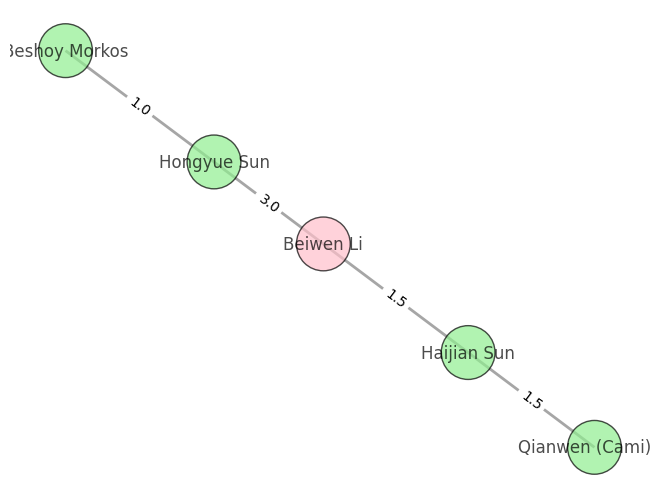

In [76]:
import math
min_weight = 0

if search_professor:
    # Find the row corresponding to the professor_search_parameter
    professor_data = df[df.index == professor_search_parameter]

    if not professor_data.empty:
        # Extract the professor's related professors and their weights
        related_professors = professor_data['related_professors'].values[0]
        
        # Create a graph for the specific professor and their related professors
        G = nx.Graph()
        
        # Add the initial professor as the first node
        G.add_node(professor_search_parameter)
        
        # Define a set to track all nodes (professors) to avoid duplicates
        added_nodes = {professor_search_parameter}
        
        # Define a set to track which professors we have processed in BFS
        visited = set([professor_search_parameter])
        
        # Perform BFS for 1st, 2nd, and further layers
        layer_queue = [(professor_search_parameter, related_professors)]  # (professor, related_professors)
        
        # For each layer, we'll expand the related professors
        while layer_queue:
            current_layer = layer_queue.pop(0)  # Get the next professor and their related professors
            current_professor, related_professors = current_layer
            
            # Add all related professors from this layer
            for related_professor, weight in related_professors:
                if min_weight > weight:
                        continue    
                
                if related_professor not in added_nodes:
                    G.add_node(related_professor)
                    G.add_edge(current_professor, related_professor, weight=weight)
                    added_nodes.add(related_professor)
                    visited.add(related_professor)  # Mark as visited

                    # Add all related professors of the current professor to the queue for the next layer
                    if related_professor in df.index:
                        next_layer_professors = df.loc[related_professor, 'related_professors']

                        print(next_layer_professors)

                        if type(next_layer_professors) != list:
                            if math.isnan(next_layer_professors):
                                continue

                        # Only add to the queue if this professor hasn't been visited already
                        for next_related_professor, _ in next_layer_professors:                            
                            if next_related_professor not in visited:
                                layer_queue.append((related_professor, next_layer_professors))

        for edge in G.edges(data=True):
            edge[2]['label'] = str(edge[2]['weight'])
            edge[2]['title'] = str(edge[2]['weight'])
            edge[2]['font'] = {'size': 12, 'weight': 'normal', 'color': 'white', 'strokeWidth': 0.}  # Adjust font size, weight, and color

        
        # Use spring_layout with fixed edge length
        pos = nx.spring_layout(G, k=k, seed=42)

        node_colors = ["pink" if node == professor_search_parameter else "lightgreen" for node in G.nodes]

        # Draw the graph with better edge styling
        nx.draw(
            G, pos, with_labels=True, node_color=node_colors, node_size=1500,
            font_size=12, font_weight='normal', edge_color='gray', width=2,
            alpha=0.7, edgecolors="black"
        )
        
        # Draw the edge labels (weights)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", select_menu=True, filter_menu=True)
       
        nt.set_options("""
        var options = {
            "physics": {
                "barnesHut": {
                    "theta": 0.1,
                    "gravitationalConstant": -8200,
                    "springLength": 85,
                    "springConstant": 0.215,
                    "damping": 0.22,
                    "avoidOverlap": 0.12
                },
                "maxVelocity": 19,
                "minVelocity": 0.75,
                "timestep": 0.01
            }
        }
        """)
        """
        options = 
        var options = {
            "physics": {
                "barnesHut": {
                    "theta": 0.1,
                    "gravitationalConstant": -8200,
                    "springLength": 85,
                    "springConstant": 0.215,
                    "damping": 0.22,
                    "avoidOverlap": 0.12,
                },
                "maxVelocity": 19,
                "minVelocity": 0.75,
                "timestep": 0.01
            }
        }
        
        
        nt.set_options(options)
        """
        nt.from_nx(G)
        
        
        nt.show(f'{professor_search_parameter.replace(" ", "_")}.html', notebook=False)

        #nt.show('nx.html')

        # Title with the professor's name
        #plt.title(f"Professor: {professor_search_parameter} and Related Professors", fontsize=14)
        
        # Adjust layout and remove tight_layout to avoid the warning
        #plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        #plt.show()

    else:
        print(f"Professor '{professor_search_parameter}' not found in the dataset.")
